# Thrust between the Earth and the Moon
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example demonstrates the a basic use of thrust in the Earth-Moon system.

Thrust is implemented to be of constant magnitude, and be co-linear with velocity, pushing the simulated vehicle from behind.
In addition to the acceleration from the thrust, a basic model is setup, consisting of the acceleration of the Earth, Moon, and Sun, only considering them as Point Masses.

The mass of the vehicle is also propagated, using a mass rate model made to be consistent with the rocket thrust used.

How to setup dependent variables to save the mass and altitude of the vehicle over time is also demonstrated.

Termination settings based on the minimum mass of the vehicle and its maximum altitude are also shown.

Finally, how to plot the trajectory of the vehicle and of the Moon in 3D is demonstrated.
For this, this example also shows how to extract the position of the Moon over time from SPICE.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# Load standard modules
import numpy as np
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel import constants
from tudatpy.util import result2array

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the position of various bodies such as the Earth can be make known to `tudatpy`.

Then, the start and end simulation epochs are setups. In this case, the start epoch is set to `1e7`, corresponding to 10 million seconds ($\approx$ 115.74 days) after the 1st of January 2000.

The times should always be specified in seconds since J2000.
Please refer to the API documentation of the `time_conversion module` [here](https://tudatpy.readthedocs.io/en/latest/time_conversion.html) for more information on this.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs (total simulation time of 30 days)
simulation_start_epoch = 1.0e7
simulation_end_epoch = 1.0e7 + 30.0 * constants.JULIAN_DAY

## Environment setup
Let’s create the environment for our simulation. This setup covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the bodies
Bodies can be created by making a list of strings with the bodies that is to be included in the simulation.

The default body settings (such as atmosphere, body shape, rotation model) are taken from `SPICE`.

These settings can be adjusted. Please refere to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Define bodies in simulation
bodies_to_create = ["Sun", "Earth", "Moon"]

# Create bodies in simulation
body_settings = environment_setup.get_default_body_settings(bodies_to_create)
system_of_bodies = environment_setup.create_system_of_bodies(body_settings)

### Create the vehicle
Let's now create the 5000kg Vehicle for which the trajectory bewteen the Earth and the Moon will be propagated.

In [4]:
# Create the vehicle body in the environment
system_of_bodies.create_empty_body("Vehicle")
system_of_bodies.get_body("Vehicle").set_constant_mass(5e3)

## Propagation setup
Now that the environment is created, the propagation setup is defined.

First, the bodies to be propagated and the central bodies will be defined.
Central bodies are the bodies with respect to which the state of the respective propagated bodies is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["Vehicle"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Define the thrust guidance settings
Let's now define the thrust guidance settings for our Vehicle.

First, the `thrust_direction_settings` are setup so that the thrust is always acting aligned with the velocity vector of the vehicle, making sure that the orbit is continuously raised.

Then, the `thrust_magnitude_settings` are setup to indicate that a constant thrust of 10N is used.

In [6]:
# Define the direction of the thrust as colinear with the velocity of the orbiting vehicle, pushing it from behind
thrust_direction_settings = (
    propagation_setup.thrust.thrust_direction_from_state_guidance(
        central_body="Earth",
        is_colinear_with_velocity=True,
        direction_is_opposite_to_vector=False ) )

# Define the thrust magnitude as constant
thrust_magnitude_settings = (
    propagation_setup.thrust.constant_thrust_magnitude(
        thrust_magnitude=10.0, specific_impulse=5e3 ) )

### Create the acceleration model
First off, the acceleration settings that act on the Vehicle are to be defined.
In this case, these consist in the followings:
- Acceleration from the constant thrust, using the settings defined earlier.
- Graviational acceleration from the Earth, the Moon, and the Sun, all modeled as Point Masses.

The acceleration settings defined are then applied to the Vehicle in a dictionary.

This dictionary is finally input to the propagation setup to create the acceleration models.

In [7]:
# Define the accelerations acting on the vehicle
acceleration_on_vehicle = dict(
    Vehicle=[
        # Define the thrust acceleration from its direction and magnitude
        propagation_setup.acceleration.thrust_from_direction_and_magnitude(
            thrust_direction_settings=thrust_direction_settings,
            thrust_magnitude_settings=thrust_magnitude_settings,
        )
    ],
    # Define the acceleration due to the Earth, Moon, and Sun as Point Mass
    Earth=[propagation_setup.acceleration.point_mass_gravity()],
    Moon=[propagation_setup.acceleration.point_mass_gravity()],
    Sun=[propagation_setup.acceleration.point_mass_gravity()]
)

# Compile the accelerations acting on the vehicle
acceleration_dict = dict(Vehicle=acceleration_on_vehicle)

# Create the acceleration models from the acceleration mapping dictionary
acceleration_models = propagation_setup.create_acceleration_models(
    body_system=system_of_bodies,
    selected_acceleration_per_body=acceleration_dict,
    bodies_to_propagate=bodies_to_propagate,
    central_bodies=central_bodies
)

### Define the initial state
The initial state of the vehicle that will be propagated is now defined. 

In this example, this state is very straightforwardly set directly in cartesian coordinates.

The Vehicle will thus start 8000km from the center of the Earth, at a velocity of 7.5km/s.

In [8]:
# Get system initial state (in cartesian coordinates)
system_initial_state = np.array([8.0e6, 0, 0, 0, 7.5e3, 0])

### Define dependent variables to save
In this example, we are interested in saving not only the propagated state of the satellite over time, but also a set of so-called dependent variables, that are to be computed (or extracted and saved) at each integration step.

[This page](https://tudatpy.readthedocs.io/en/latest/dependent_variable.html) of the tudatpy API website provides a detailled explanation of all the dependent variables that are available.

In [9]:
# Create a dependent variable to save the altitude of the vehicle w.r.t. Earth over time
vehicle_altitude_dep_var = propagation_setup.dependent_variable.altitude( "Vehicle", "Earth" )

# Create a dependent variable to save the mass of the vehicle over time
vehicle_mass_dep_var = propagation_setup.dependent_variable.body_mass( "Vehicle" )

# Define list of dependent variables to save
dependent_variables_to_save = [vehicle_altitude_dep_var, vehicle_mass_dep_var]

### Create the termination settings
Let's now define a set of termination conditions. In this setup, once a single one of them is fulfilled, the propagation stops.

These conditions are the following:
- Stop when the altitude get above 100,000 km.
- Stop when the vehicle has a mass of 4000kg (burned 1000kg of propellant).
- Stop when the vehicle reaches the specified end epoch (after 30 days).

In [10]:
# Create a termination setting to stop when altitude of the vehicle is above 100e3 km
termination_distance_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings = vehicle_altitude_dep_var,
        limit_value = 100e6,
        use_as_lower_limit = False)

# Create a termination setting to stop when the vehicle has a mass below 4e3 kg
termination_mass_settings = propagation_setup.propagator.dependent_variable_termination(
        dependent_variable_settings = vehicle_mass_dep_var,
        limit_value = 4000.0,
        use_as_lower_limit = True)

# Create a termination setting to stop at the specified simulation end epoch
termination_time_settings = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Setup a hybrid termination setting to stop the simulation when one of the aforementionned termination setting is reached
termination_condition = propagation_setup.propagator.hybrid_termination(
    [termination_distance_settings, termination_mass_settings, termination_time_settings],
    fulfill_single_condition = True)

### Create the propagator settings
The propagator settings are now defined.

As usual, translational propagation settings are defined, using a Cowell propagator.

Then, mass propagation settings are also defined. The mass rate from the vehicle is setup to be consistent with the thrust used. The vehicle then looses mass as it looses propellant.

Finally, a multitype propagator is defined, encompassing both the translational and the mass propagators.

In [11]:
# Create the translational propagation settings (use a Cowell propagator)
translational_propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    system_initial_state,
    termination_condition,
    propagation_setup.propagator.cowell,
    output_variables=[vehicle_altitude_dep_var, vehicle_mass_dep_var]
)

# Create a mass rate model so that the vehicle looses mass according to how much thrust acts on it
mass_rate_settings = dict(Vehicle=[propagation_setup.mass_rate.from_thrust()])
mass_rate_models = propagation_setup.create_mass_rate_models(
    system_of_bodies,
    mass_rate_settings,
    acceleration_models
)
# Create the mass propagation settings
mass_propagator_settings = propagation_setup.propagator.mass(
    bodies_to_propagate,
    mass_rate_models,
    [5e3], # initial vehicle mass
    termination_condition )

# Combine the translational and mass propagator settings
propagator_settings = propagation_setup.propagator.multitype(
    [translational_propagator_settings, mass_propagator_settings],
    termination_condition,
    [vehicle_altitude_dep_var, vehicle_mass_dep_var])

### Create the integrator settings
The last step before starting the simulation is to setup the integrator that will be used.

In this case, a RKF7(8) variable step integrator is used, which has a tolerance of $10^{-10}$, can take steps from 0.01s to 1 day, and starts at an initial step size of 10s.

In [12]:
# Setup the variable step integrator time step sizes
initial_time_step = 10.0
minimum_time_step = 0.01
maximum_time_step = 86400
# Setup the tolerance of the variable step integrator
tolerance = 1e-10

# Create numerical integrator settings (using a RKF7(8) coefficient set)
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    simulation_start_epoch,
    initial_time_step,
    propagation_setup.integrator.rkf_78,
    minimum_time_step,
    maximum_time_step,
    relative_error_tolerance=tolerance,
    absolute_error_tolerance=tolerance)

## Propagate the orbit
The orbit from the Earth to the Moon is now ready to be propagated.

This is done by calling the `SingleArcSimulator()` function of the `numerical_simulation module`.
This function requires the `system_of_bodies`, `integrator_settings`, and `propagator_settings` that have all been defined earlier.

After this, the history of the propagated state over time, containing both the position and velocity history, is extracted.
This history, taking the form of a dictionary, is then converted to an array containing 7 columns:
- Column 0: Time history, in seconds since J2000.
- Columns 1 to 3: Position history, in meters, in the frame that was specified in the `body_settings`.
- Columns 4 to 6: Velocity history, in meters per second, in the frame that was specified in the `body_settings`.

The same is done with the dependent variable history. The column indexes corresponding to a given dependent variable in the `dep_vars` variable are printed when the simulation is run, when `SingleArcSimulator()` is called.
Do mind that converting to an ndarray using the `result2array()` utility will shift these indexes, since the first column (index 0) will then be the times.

In [13]:
# Instantiate the dynamics simulator and run the simulation
dynamics_simulator = numerical_simulation.SingleArcSimulator(
    system_of_bodies, integrator_settings, propagator_settings, print_dependent_variable_data=True
)

# Extract the state and dependent variable history
state_history = dynamics_simulator.state_history
dependent_variable_history = dynamics_simulator.dependent_variable_history

# Convert the dictionaries to multi-dimensional arrays
vehicle_array = result2array(state_history)
dep_var_array = result2array(dependent_variable_history)

State vector contains: 
Vector entries, Vector contents
[0:6], translational state of body Vehicle
[6], body mass state of body Vehicle
Dependent variables being saved, output vector contains: 
Vector entry, Vector contents
0, Altitude of Vehicle w.r.t. Earth
1, Current body mass of Vehicle


### Get Moon state from SPICE
The state of the Moon at the epochs at which the propagation was run is now extracted from the SPICE kernel.

In [14]:
# Retrieve the Moon trajectory over vehicle propagation epochs from spice
moon_states_from_spice = {
    epoch:spice.get_body_cartesian_state_at_epoch("Moon", "Earth", "J2000", "None", epoch)
    for epoch in list(state_history.keys())
}
# Convert the dictionary to a mutli-dimensional array
moon_array = result2array(moon_states_from_spice)

## Post-process the propagation results
The results of the propagation are then processed to a more user-friendly form.

### Altitude over time
Let's first plot the altitude of the vehicle over time, as given in the second column of the dependent variable array (the first one being the epochs).

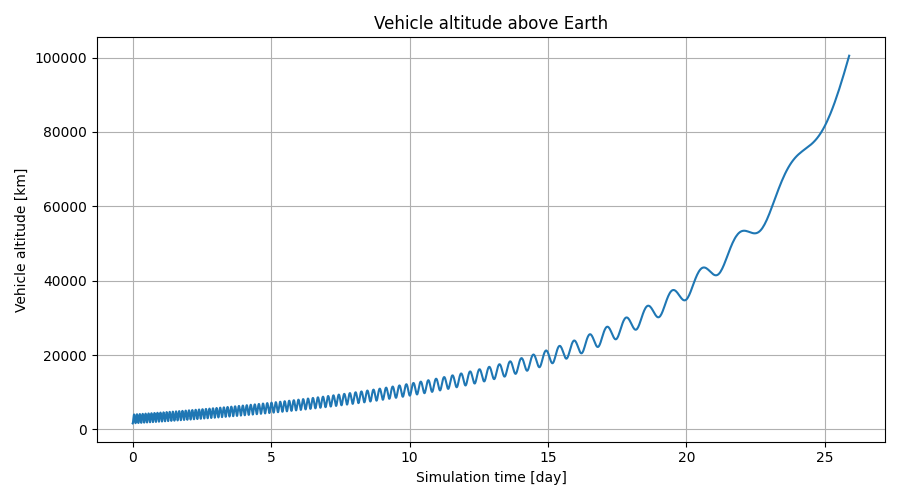

In [15]:
# Convert the time to days
time_days = (vehicle_array[:,0] - vehicle_array[0,0])/constants.JULIAN_DAY

# Create a figure for the altitude of the vehicle above Earth
fig1 = plt.figure(figsize=(9, 5))
ax1 = fig1.add_subplot(111)
ax1.set_title(f"Vehicle altitude above Earth")

# Plot the altitude of the vehicle over time
ax1.plot(time_days, dep_var_array[:,1]/1e3)

# Add a grid and axis labels to the plot
ax1.grid(), ax1.set_xlabel("Simulation time [day]"), ax1.set_ylabel("Vehicle altitude [km]")

# Use a tight layout for the figure (do last to avoid trimming axis)
fig1.tight_layout()

### Vehicle mass over time
The mass of the vehicle over time is now plotted. This shows that, as expected, the propellant being used for thrust gets removed from the vehicle mass.

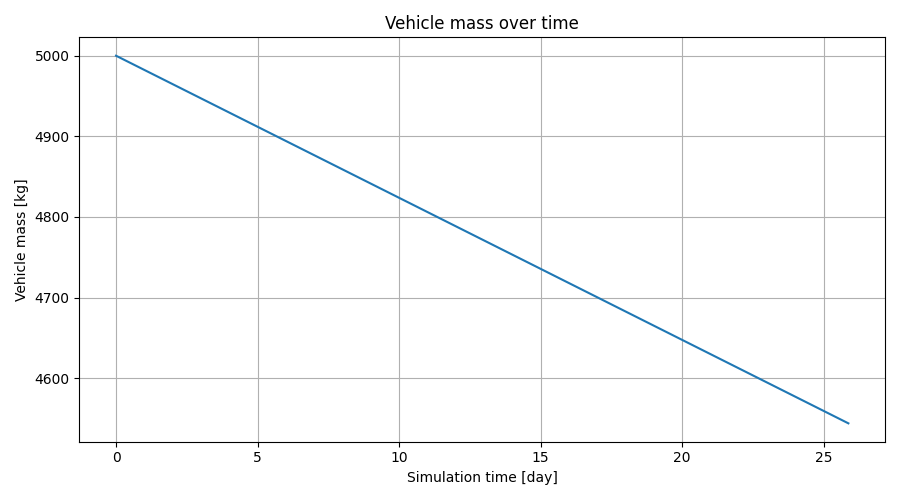

In [16]:
# Create a figure for the altitude of the vehicle above Earth
fig2 = plt.figure(figsize=(9, 5))
ax2 = fig2.add_subplot(111)
ax2.set_title(f"Vehicle mass over time")

# Plot the mass of the vehicle over time
ax2.plot(time_days, dep_var_array[:,2])

# Add a grid and axis labels to the plot
ax2.grid(), ax2.set_xlabel("Simulation time [day]"), ax2.set_ylabel("Vehicle mass [kg]")

# Use a tight layout for the figure (do last to avoid trimming axis)
fig2.tight_layout()

### 3D Projection
Finally, let's plot the state of the vehicle and of the Moon in 3 dimensions.

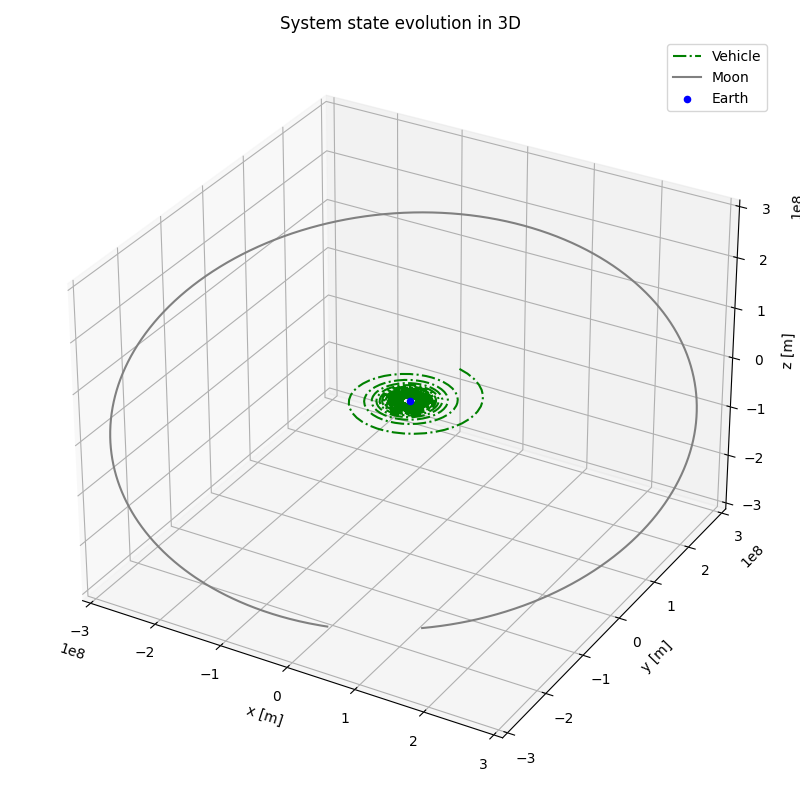

In [17]:
# Create a figure with a 3D projection for the Moon and vehicle trajectory around Earth
fig3 = plt.figure(figsize=(8, 8))
ax3 = fig3.add_subplot(111, projection="3d")
ax3.set_title(f"System state evolution in 3D")

# Plot the vehicle and Moon positions as curve, and the Earth as a marker
ax3.plot(vehicle_array[:,1], vehicle_array[:,2], vehicle_array[:,3], label="Vehicle", linestyle="-.", color="green")
ax3.plot(moon_array[:,1], moon_array[:,2], moon_array[:,3], label="Moon", linestyle="-", color="grey")
ax3.scatter(0.0, 0.0, 0.0, label="Earth", marker="o", color="blue")

# Add a legend, set the plot limits, and add axis labels
ax3.legend()
ax3.set_xlim([-3E8, 3E8]), ax3.set_ylim([-3E8, 3E8]), ax3.set_zlim([-3E8, 3E8])
ax3.set_xlabel("x [m]"), ax3.set_ylabel("y [m]"), ax3.set_zlabel("z [m]")

# Use a tight layout for the figure (do last to avoid trimming axis)
fig3.tight_layout()